# HDFS Template Transformer Pretraining

In [18]:
import json
import math
import os
import random
import time
from pathlib import Path
from collections import defaultdict

import yaml
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

In [19]:
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD
cfg = yaml.safe_load((REPO_ROOT / 'configs/train_hdfs.yaml').read_text())
random.seed(cfg.get('seed', 42))
torch.manual_seed(cfg.get('seed', 42))
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.get('seed', 42))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")


Running on device: cuda


In [20]:
def read_sequences(parquet_path: Path):
    table = pq.read_table(parquet_path, columns=['templates'])
    sequences = []
    for seq in table.column(0).to_pylist():
        if seq and len(seq) > 1:
            sequences.append([int(x) for x in seq])
    return sequences

class TemplateSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

class TemplateBatchCollator:
    def __init__(self, pad_id: int, max_length: int):
        self.pad_id = pad_id
        self.max_length = max_length
    def __call__(self, batch):
        if not batch:
            raise ValueError('Empty batch received')
        truncated = []
        for seq in batch:
            seq = seq[: self.max_length]
            if len(seq) < 2:
                continue
            truncated.append(seq)
        if not truncated:
            # if every sequence shortened to <2, keep at least original first
            truncated = [batch[0][: self.max_length]]
        max_len = max(len(seq) for seq in truncated)
        input_len = max_len - 1
        bs = len(truncated)
        input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
        for i, seq in enumerate(truncated):
            seq_len = len(seq)
            if seq_len < 2:
                continue
            src = seq[:-1]
            tgt = seq[1:]
            input_ids[i, : len(src)] = torch.tensor(src, dtype=torch.long)
            target_ids[i, : len(tgt)] = torch.tensor(tgt, dtype=torch.long)
            attention_mask[i, : len(src)] = 1
        return {
            'input_ids': input_ids,
            'target_ids': target_ids,
            'attention_mask': attention_mask,
        }


In [21]:
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                 ffn_dim: int, dropout: float, max_length: int):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(), persistent=False)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        pos = self.positional[:, :seq_len, :]
        x = x + pos
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        key_padding = attention_mask == 0
        x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        return logits


In [22]:
def make_dataloaders(cfg, pad_id, max_seq_len):
    data_cfg = cfg['data']
    train_sequences = read_sequences((REPO_ROOT / data_cfg['train_file']).resolve())
    val_sequences = read_sequences((REPO_ROOT / data_cfg['val_file']).resolve())
    test_sequences = read_sequences((REPO_ROOT / data_cfg['test_file']).resolve())

    collator = TemplateBatchCollator(pad_id=pad_id, max_length=max_seq_len)

    train_loader = DataLoader(
        TemplateSequenceDataset(train_sequences),
        batch_size=cfg['training']['batch_size'],
        shuffle=True,
        collate_fn=collator,
    )
    val_loader = DataLoader(
        TemplateSequenceDataset(val_sequences),
        batch_size=cfg['training']['eval_batch_size'],
        shuffle=False,
        collate_fn=collator,
    )
    test_loader = DataLoader(
        TemplateSequenceDataset(test_sequences),
        batch_size=cfg['training']['eval_batch_size'],
        shuffle=False,
        collate_fn=collator,
    )
    return train_loader, val_loader, test_loader


In [23]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            tokens = (target_ids != criterion.ignore_index).sum().item()
            total_loss += loss.item() * tokens
            total_tokens += tokens
    if total_tokens == 0:
        return float('inf')
    avg_loss = total_loss / total_tokens
    return avg_loss, math.exp(min(avg_loss, 50))


In [24]:
# Prepare data and model
model_cfg = cfg['model']
seq_cfg = cfg['sequence']
data_cfg = cfg['data']

vocab = json.loads((REPO_ROOT / data_cfg['vocab_path']).read_text())
base_vocab_size = len(vocab.get('id_to_template', []))
pad_strategy = data_cfg.get('pad_token_strategy', 'vocab_size')
if pad_strategy == 'vocab_size':
    pad_id = base_vocab_size
    vocab_size = base_vocab_size + 1
else:
    pad_id = int(pad_strategy)
    vocab_size = max(base_vocab_size + 1, pad_id + 1)

max_seq_len = seq_cfg.get('max_length', 100)

train_loader, val_loader, test_loader = make_dataloaders(cfg, pad_id=pad_id, max_seq_len=max_seq_len)

model = TemplateTransformer(
    vocab_size=vocab_size,
    pad_id=pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['optimizer']['lr'], betas=tuple(cfg['optimizer']['betas']), eps=cfg['optimizer']['eps'], weight_decay=cfg['optimizer']['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['training']['epochs'] * max(1, len(train_loader)))
use_amp = cfg.get('precision', {}).get('mixed_precision', '').lower() == 'fp16' and device.type == 'cuda'
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 4,825,719


In [25]:
# Enhanced Training Loop with tqdm, sample-based checkpointing, and metrics tracking
best_val = float('inf')
patience = cfg['training'].get('patience', 3)
min_delta = cfg['training'].get('min_delta', 1e-3)
wait = 0

checkpoint_dir = (REPO_ROOT / cfg['checkpointing']['output_dir']).resolve()
checkpoint_dir.mkdir(parents=True, exist_ok=True)
best_path = checkpoint_dir / 'best.pt'
last_path = checkpoint_dir / 'last.pt'

# Metrics tracking
train_losses = []
val_losses = []
val_ppls = []
epoch_times = []
learning_rates = []

# Sample-based checkpointing (every 1M samples)
checkpoint_every_samples = 1_000_000
total_samples_seen = 0
checkpoint_counter = 0

print(f"Training Configuration:")
print(f"  Epochs: {cfg['training']['epochs']}")
print(f"  Batch size: {cfg['training']['batch_size']}")
print(f"  Learning rate: {cfg['optimizer']['lr']}")
print(f"  Total training batches: {len(train_loader)}")
print(f"  Checkpoint every: {checkpoint_every_samples:,} samples")
print(f"  Mixed precision: {use_amp}")
print(f"\nStarting training...\n")

for epoch in range(1, cfg['training']['epochs'] + 1):
    model.train()
    epoch_loss = 0.0
    token_count = 0
    batch_losses = []
    start = time.time()
    
    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg['training']['epochs']}", 
                leave=True, dynamic_ncols=True)
    
    for batch_idx, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        batch_size = input_ids.size(0)
        total_samples_seen += batch_size
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg['training']['max_grad_norm'])
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        # Track metrics
        tokens = (target_ids != pad_id).sum().item()
        epoch_loss += loss.item() * tokens
        token_count += tokens
        batch_losses.append(loss.item())
        
        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg_loss': f"{epoch_loss/max(1, token_count):.4f}",
            'lr': f"{current_lr:.2e}",
            'samples': f"{total_samples_seen:,}"
        })
        
        # Sample-based checkpointing
        if total_samples_seen >= (checkpoint_counter + 1) * checkpoint_every_samples:
            checkpoint_counter += 1
            sample_ckpt_path = checkpoint_dir / f'checkpoint_{checkpoint_counter}M.pt'
            torch.save({
                'epoch': epoch,
                'batch_idx': batch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'total_samples_seen': total_samples_seen,
                'pad_id': pad_id,
                'vocab_size': vocab_size,
                'config': cfg
            }, sample_ckpt_path)
            tqdm.write(f"  → Checkpoint saved at {total_samples_seen:,} samples: {sample_ckpt_path.name}")
    
    # Epoch-level statistics
    train_loss = epoch_loss / max(1, token_count)
    epoch_time = time.time() - start
    current_lr = optimizer.param_groups[0]['lr']
    
    # Validation
    val_loss, val_ppl = evaluate(model, val_loader, criterion)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ppls.append(val_ppl)
    epoch_times.append(epoch_time)
    learning_rates.append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val PPL:    {val_ppl:.2f}")
    print(f"  Time:       {epoch_time:.1f}s")
    print(f"  LR:         {current_lr:.2e}")
    print(f"  Samples:    {total_samples_seen:,}")
    
    # Early stopping logic
    improved = val_loss + min_delta < best_val
    if improved:
        best_val = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'total_samples_seen': total_samples_seen,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_ppl': val_ppl,
            'pad_id': pad_id,
            'vocab_size': vocab_size,
            'config': cfg
        }, best_path)
        print(f"  ✓ Best model saved (val_loss improved to {val_loss:.4f})")
    else:
        wait += 1
        print(f"  ✗ No improvement (patience {wait}/{patience})")
        if wait >= patience:
            print('\n⚠ Early stopping triggered.')
            break
    print()

# Save final checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'total_samples_seen': total_samples_seen,
    'train_loss': train_loss,
    'val_loss': val_loss,
    'pad_id': pad_id,
    'vocab_size': vocab_size,
    'config': cfg
}, last_path)

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"  Total Epochs: {epoch}")
print(f"  Total Samples: {total_samples_seen:,}")
print(f"  Best Val Loss: {best_val:.4f}")
print(f"  Checkpoints Saved: {checkpoint_counter + 2} (best, last, {checkpoint_counter} sample-based)")
print(f"{'='*60}\n")

Training Configuration:
  Epochs: 5
  Batch size: 64
  Learning rate: 0.0003
  Total training batches: 7190
  Checkpoint every: 1,000,000 samples
  Mixed precision: True

Starting training...



Epoch 1/5:   0%|          | 0/7190 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Epoch 1 Summary:
  Train Loss: 0.5256
  Val Loss:   0.5181
  Val PPL:    1.68
  Time:       56.2s
  LR:         2.71e-04
  Samples:    460,119
  ✓ Best model saved (val_loss improved to 0.5181)



Epoch 2/5:   0%|          | 0/7190 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.4948
  Val Loss:   0.5099
  Val PPL:    1.67
  Time:       56.8s
  LR:         1.96e-04
  Samples:    920,238
  ✓ Best model saved (val_loss improved to 0.5099)



Epoch 3/5:   0%|          | 0/7190 [00:00<?, ?it/s]

  → Checkpoint saved at 1,000,046 samples: checkpoint_1M.pt

Epoch 3 Summary:
  Train Loss: 0.4912
  Val Loss:   0.5130
  Val PPL:    1.67
  Time:       57.4s
  LR:         1.04e-04
  Samples:    1,380,357
  ✗ No improvement (patience 1/3)


Epoch 3 Summary:
  Train Loss: 0.4912
  Val Loss:   0.5130
  Val PPL:    1.67
  Time:       57.4s
  LR:         1.04e-04
  Samples:    1,380,357
  ✗ No improvement (patience 1/3)



Epoch 4/5:   0%|          | 0/7190 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.4896
  Val Loss:   0.5139
  Val PPL:    1.67
  Time:       57.2s
  LR:         2.86e-05
  Samples:    1,840,476
  ✗ No improvement (patience 2/3)



Epoch 5/5:   0%|          | 0/7190 [00:00<?, ?it/s]

  → Checkpoint saved at 2,000,028 samples: checkpoint_2M.pt

Epoch 5 Summary:
  Train Loss: 0.4889
  Val Loss:   0.5116
  Val PPL:    1.67
  Time:       57.4s
  LR:         0.00e+00
  Samples:    2,300,595
  ✗ No improvement (patience 3/3)

⚠ Early stopping triggered.

Training Complete!
  Total Epochs: 5
  Total Samples: 2,300,595
  Best Val Loss: 0.5099
  Checkpoints Saved: 4 (best, last, 2 sample-based)


Epoch 5 Summary:
  Train Loss: 0.4889
  Val Loss:   0.5116
  Val PPL:    1.67
  Time:       57.4s
  LR:         0.00e+00
  Samples:    2,300,595
  ✗ No improvement (patience 3/3)

⚠ Early stopping triggered.

Training Complete!
  Total Epochs: 5
  Total Samples: 2,300,595
  Best Val Loss: 0.5099
  Checkpoints Saved: 4 (best, last, 2 sample-based)



## Training Visualization & Analysis

Saved training curves to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/training_curves.png


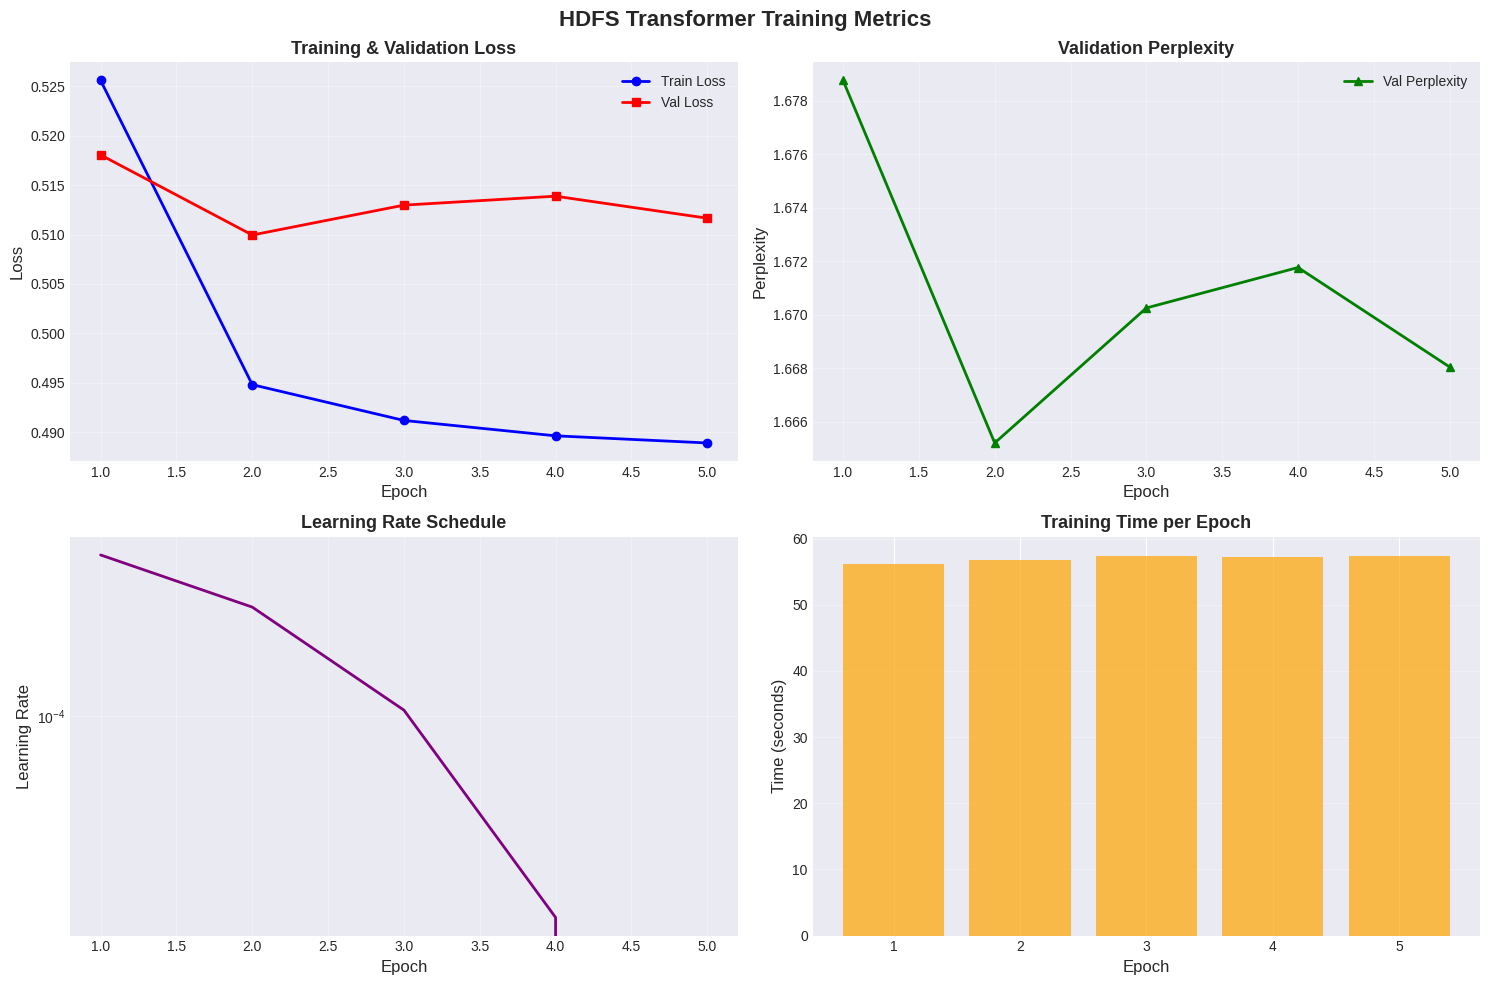

In [26]:
# Plot Training Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('HDFS Transformer Training Metrics', fontsize=16, fontweight='bold')

epochs_range = range(1, len(train_losses) + 1)

# 1. Training & Validation Loss
ax1 = axes[0, 0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs_range, val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Validation Perplexity
ax2 = axes[0, 1]
ax2.plot(epochs_range, val_ppls, 'g-^', label='Val Perplexity', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Perplexity', fontsize=12)
ax2.set_title('Validation Perplexity', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Learning Rate Schedule
ax3 = axes[1, 0]
ax3.plot(epochs_range, learning_rates, 'purple', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Epoch Time
ax4 = axes[1, 1]
ax4.bar(epochs_range, epoch_times, color='orange', alpha=0.7)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Time (seconds)', fontsize=12)
ax4.set_title('Training Time per Epoch', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
print(f"Saved training curves to: {checkpoint_dir / 'training_curves.png'}")
plt.show()

In [27]:
# Create detailed training history DataFrame
training_history = pd.DataFrame({
    'epoch': list(epochs_range),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_perplexity': val_ppls,
    'learning_rate': learning_rates,
    'epoch_time_sec': epoch_times
})

# Calculate additional statistics
training_history['cumulative_time'] = training_history['epoch_time_sec'].cumsum()
training_history['avg_time_per_epoch'] = training_history['cumulative_time'] / training_history['epoch']
training_history['loss_improvement'] = training_history['val_loss'].diff()
training_history['ppl_improvement'] = training_history['val_perplexity'].diff()

# Save to CSV
history_path = checkpoint_dir / 'training_history.csv'
training_history.to_csv(history_path, index=False)
print(f"Saved training history to: {history_path}\n")

# Display summary statistics
print("="*70)
print("TRAINING HISTORY SUMMARY")
print("="*70)
print(training_history.to_string(index=False))
print("\n" + "="*70)

# Best metrics
best_epoch = training_history.loc[training_history['val_loss'].idxmin()]
print(f"\nBest Model Statistics (Epoch {int(best_epoch['epoch'])}):")
print(f"  Train Loss:        {best_epoch['train_loss']:.4f}")
print(f"  Val Loss:          {best_epoch['val_loss']:.4f}")
print(f"  Val Perplexity:    {best_epoch['val_perplexity']:.2f}")
print(f"  Learning Rate:     {best_epoch['learning_rate']:.2e}")

# Overall statistics
print(f"\nOverall Training Statistics:")
print(f"  Total Epochs:           {len(train_losses)}")
print(f"  Total Training Time:    {training_history['cumulative_time'].iloc[-1]:.1f}s ({training_history['cumulative_time'].iloc[-1]/60:.1f}m)")
print(f"  Avg Time per Epoch:     {training_history['epoch_time_sec'].mean():.1f}s")
print(f"  Total Samples Seen:     {total_samples_seen:,}")
print(f"  Final Train Loss:       {train_losses[-1]:.4f}")
print(f"  Final Val Loss:         {val_losses[-1]:.4f}")
print(f"  Best Val Loss:          {min(val_losses):.4f}")
print(f"  Loss Reduction:         {train_losses[0] - min(val_losses):.4f}")
print(f"  Sample Checkpoints:     {checkpoint_counter}")

Saved training history to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/training_history.csv

TRAINING HISTORY SUMMARY
 epoch  train_loss  val_loss  val_perplexity  learning_rate  epoch_time_sec  cumulative_time  avg_time_per_epoch  loss_improvement  ppl_improvement
     1    0.525584  0.518051        1.678753       0.000271       56.173103        56.173103           56.173103               NaN              NaN
     2    0.494810  0.509946        1.665202       0.000196       56.780680       112.953783           56.476892         -0.008105        -0.013551
     3    0.491190  0.512972        1.670248       0.000104       57.352710       170.306493           56.768831          0.003026         0.005046
     4    0.489635  0.513877        1.671760       0.000029       57.192230       227.498722           56.874681          0.000905         0.001512
     5    0.488913  0.511650        1.668041       0.000000       57.409128       284.907851           56.981570         -0.002227  

## Model Evaluation & Final Statistics

In [28]:
# Load best checkpoint and evaluate comprehensively
print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)

state = torch.load(best_path, map_location=device)
model.load_state_dict(state['model_state_dict'])

print(f"\nLoaded best checkpoint from epoch {state.get('epoch', 'N/A')}")
print(f"Checkpoint trained on {state.get('total_samples_seen', 'N/A'):,} samples\n")

# Evaluate on all splits with progress bars
print("Evaluating on validation set...")
val_loss, val_ppl = evaluate(model, val_loader, criterion)

print("Evaluating on test set...")
test_loss, test_ppl = evaluate(model, test_loader, criterion)

# Print results
print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)
print(f"\nValidation Set:")
print(f"  Loss:       {val_loss:.4f}")
print(f"  Perplexity: {val_ppl:.2f}")

print(f"\nTest Set:")
print(f"  Loss:       {test_loss:.4f}")
print(f"  Perplexity: {test_ppl:.2f}")

# Model size and complexity
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 4 / (1024 ** 2)  # Assuming float32

print(f"\nModel Statistics:")
print(f"  Total Parameters:      {total_params:,}")
print(f"  Trainable Parameters:  {trainable_params:,}")
print(f"  Model Size:            {model_size_mb:.2f} MB")
print(f"  Vocabulary Size:       {vocab_size:,}")
print(f"  Max Sequence Length:   {max_seq_len}")
print(f"  Embedding Dimension:   {model_cfg['d_model']}")
print(f"  Number of Layers:      {model_cfg['n_layers']}")
print(f"  Number of Heads:       {model_cfg['n_heads']}")

# Save comprehensive metrics
metrics = {
    'model_info': {
        'total_parameters': int(total_params),
        'trainable_parameters': int(trainable_params),
        'model_size_mb': float(model_size_mb),
        'vocab_size': int(vocab_size),
        'max_sequence_length': int(max_seq_len),
        'd_model': int(model_cfg['d_model']),
        'n_layers': int(model_cfg['n_layers']),
        'n_heads': int(model_cfg['n_heads'])
    },
    'training_info': {
        'total_epochs': len(train_losses),
        'total_samples_seen': int(total_samples_seen),
        'total_training_time_sec': float(training_history['cumulative_time'].iloc[-1]),
        'avg_epoch_time_sec': float(training_history['epoch_time_sec'].mean()),
        'sample_checkpoints_saved': int(checkpoint_counter)
    },
    'performance': {
        'best_val_loss': float(min(val_losses)),
        'best_val_perplexity': float(min(val_ppls)),
        'final_val_loss': float(val_loss),
        'final_val_perplexity': float(val_ppl),
        'test_loss': float(test_loss),
        'test_perplexity': float(test_ppl),
        'initial_train_loss': float(train_losses[0]),
        'final_train_loss': float(train_losses[-1]),
        'total_loss_reduction': float(train_losses[0] - min(val_losses))
    },
    'training_history': {
        'train_losses': [float(x) for x in train_losses],
        'val_losses': [float(x) for x in val_losses],
        'val_perplexities': [float(x) for x in val_ppls],
        'learning_rates': [float(x) for x in learning_rates],
        'epoch_times': [float(x) for x in epoch_times]
    }
}

# Save to JSON
metrics_dir = (REPO_ROOT / 'artifacts/metrics/hdfs').resolve()
metrics_dir.mkdir(parents=True, exist_ok=True)
metrics_path = metrics_dir / 'hdfs_transformer_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n{'='*70}")
print(f"Saved comprehensive metrics to: {metrics_path}")
print(f"Saved training curves to: {checkpoint_dir / 'training_curves.png'}")
print(f"Saved training history to: {checkpoint_dir / 'training_history.csv'}")
print(f"{'='*70}\n")

FINAL MODEL EVALUATION

Loaded best checkpoint from epoch 2
Checkpoint trained on 920,238 samples

Evaluating on validation set...


/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


Evaluating on test set...

EVALUATION RESULTS

Validation Set:
  Loss:       0.5099
  Perplexity: 1.67

Test Set:
  Loss:       0.4618
  Perplexity: 1.59

Model Statistics:
  Total Parameters:      4,825,719
  Trainable Parameters:  4,825,719
  Model Size:            18.41 MB
  Vocabulary Size:       119
  Max Sequence Length:   100
  Embedding Dimension:   256
  Number of Layers:      6
  Number of Heads:       8

Saved comprehensive metrics to: /home/tpi/distil_shahreyar/artifacts/metrics/hdfs/hdfs_transformer_metrics.json
Saved training curves to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/training_curves.png
Saved training history to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/training_history.csv


EVALUATION RESULTS

Validation Set:
  Loss:       0.5099
  Perplexity: 1.67

Test Set:
  Loss:       0.4618
  Perplexity: 1.59

Model Statistics:
  Total Parameters:      4,825,719
  Trainable Parameters:  4,825,719
  Model Size:            18.41 MB
  Vocabulary Si

## Performance Summary Visualization

Saved training summary to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/training_summary.png


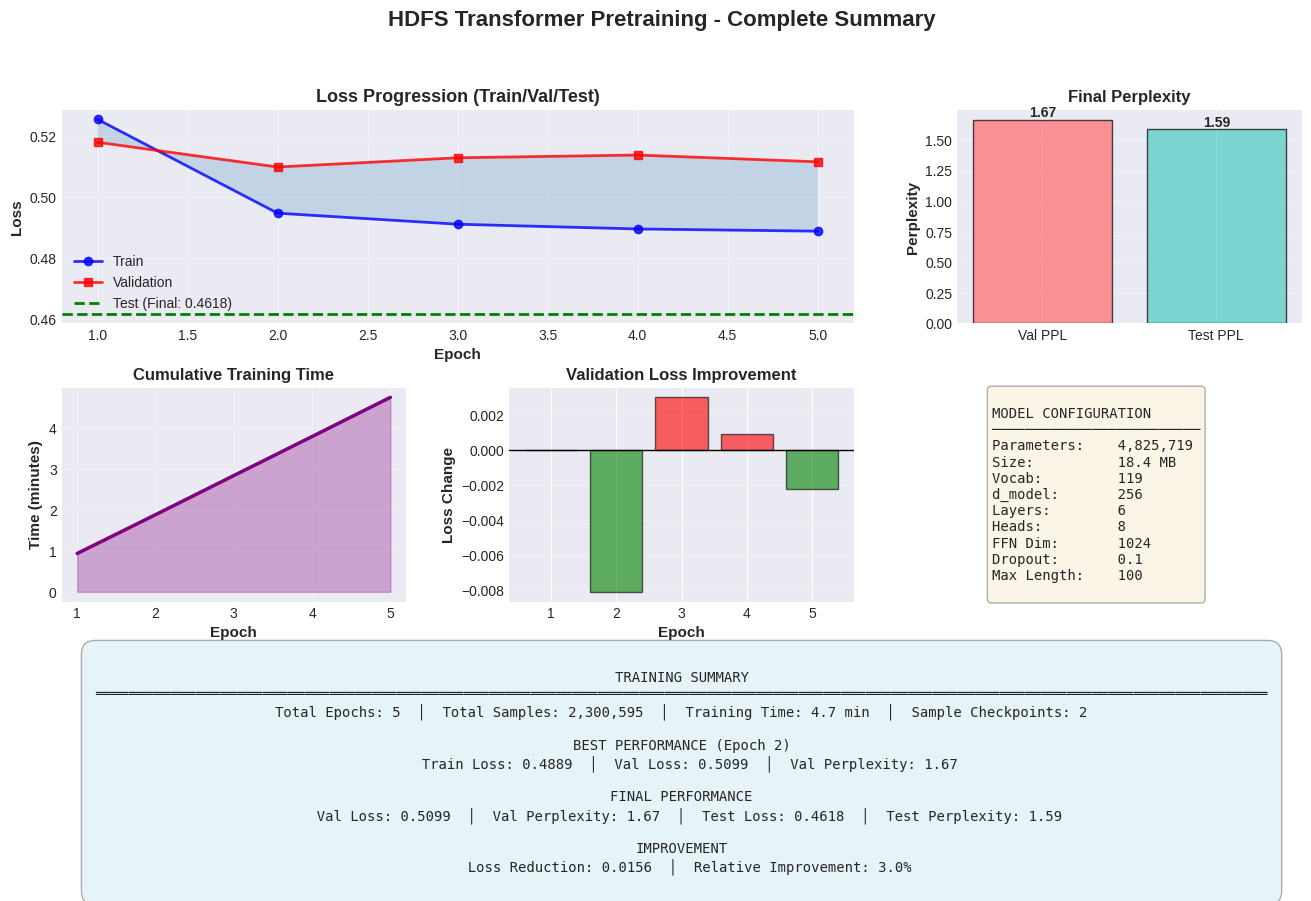

In [29]:
# Create comprehensive summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Loss Comparison (Train/Val/Test)
ax1 = fig.add_subplot(gs[0, :2])
x = list(range(1, len(train_losses) + 1))
ax1.plot(x, train_losses, 'b-o', label='Train', linewidth=2, alpha=0.8)
ax1.plot(x, val_losses, 'r-s', label='Validation', linewidth=2, alpha=0.8)
ax1.axhline(y=test_loss, color='g', linestyle='--', linewidth=2, label=f'Test (Final: {test_loss:.4f})')
ax1.fill_between(x, train_losses, val_losses, alpha=0.2)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss Progression (Train/Val/Test)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Performance Metrics Bar Chart
ax2 = fig.add_subplot(gs[0, 2])
metrics_names = ['Val PPL', 'Test PPL']
metrics_values = [val_ppl, test_ppl]
colors = ['#FF6B6B', '#4ECDC4']
bars = ax2.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
ax2.set_title('Final Perplexity', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Training Progress (Cumulative)
ax3 = fig.add_subplot(gs[1, 0])
cumulative_time = np.cumsum(epoch_times)
ax3.plot(x, cumulative_time / 60, 'purple', linewidth=2.5)
ax3.fill_between(x, 0, cumulative_time / 60, alpha=0.3, color='purple')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Time (minutes)', fontsize=11, fontweight='bold')
ax3.set_title('Cumulative Training Time', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Loss Improvement per Epoch
ax4 = fig.add_subplot(gs[1, 1])
val_loss_diff = np.diff(val_losses, prepend=val_losses[0])
colors_improvement = ['green' if x < 0 else 'red' for x in val_loss_diff]
ax4.bar(x, val_loss_diff, color=colors_improvement, alpha=0.6, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Loss Change', fontsize=11, fontweight='bold')
ax4.set_title('Validation Loss Improvement', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Model Configuration
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')
config_text = f"""
MODEL CONFIGURATION
{'─'*25}
Parameters:    {total_params:,}
Size:          {model_size_mb:.1f} MB
Vocab:         {vocab_size:,}
d_model:       {model_cfg['d_model']}
Layers:        {model_cfg['n_layers']}
Heads:         {model_cfg['n_heads']}
FFN Dim:       {model_cfg['ffn_dim']}
Dropout:       {model_cfg['dropout']}
Max Length:    {max_seq_len}
"""
ax5.text(0.1, 0.5, config_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 6. Performance Summary
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')
summary_text = f"""
TRAINING SUMMARY
{'═'*140}
Total Epochs: {len(train_losses)}  │  Total Samples: {total_samples_seen:,}  │  Training Time: {cumulative_time[-1]/60:.1f} min  │  Sample Checkpoints: {checkpoint_counter}

BEST PERFORMANCE (Epoch {training_history.loc[training_history['val_loss'].idxmin(), 'epoch']:.0f})
  Train Loss: {min(train_losses):.4f}  │  Val Loss: {min(val_losses):.4f}  │  Val Perplexity: {min(val_ppls):.2f}

FINAL PERFORMANCE
  Val Loss: {val_loss:.4f}  │  Val Perplexity: {val_ppl:.2f}  │  Test Loss: {test_loss:.4f}  │  Test Perplexity: {test_ppl:.2f}

IMPROVEMENT
  Loss Reduction: {train_losses[0] - min(val_losses):.4f}  │  Relative Improvement: {((train_losses[0] - min(val_losses)) / train_losses[0] * 100):.1f}%
"""
ax6.text(0.5, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))

fig.suptitle('HDFS Transformer Pretraining - Complete Summary', 
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig(checkpoint_dir / 'training_summary.png', dpi=300, bbox_inches='tight')
print(f"Saved training summary to: {checkpoint_dir / 'training_summary.png'}")
plt.show()

## Checkpoint Inventory & Export

In [30]:
# List all checkpoints and create inventory
import os

print("="*70)
print("CHECKPOINT INVENTORY")
print("="*70)

checkpoint_files = []
for f in sorted(checkpoint_dir.glob('*.pt')):
    size_mb = f.stat().st_size / (1024 ** 2)
    checkpoint_files.append({
        'filename': f.name,
        'size_mb': size_mb,
        'path': str(f)
    })

if checkpoint_files:
    checkpoint_df = pd.DataFrame(checkpoint_files)
    print(f"\nCheckpoint Directory: {checkpoint_dir}\n")
    print(checkpoint_df.to_string(index=False))
    print(f"\nTotal checkpoints: {len(checkpoint_files)}")
    print(f"Total size: {checkpoint_df['size_mb'].sum():.2f} MB")
    
    # Save inventory
    inventory_path = checkpoint_dir / 'checkpoint_inventory.csv'
    checkpoint_df.to_csv(inventory_path, index=False)
    print(f"\nSaved checkpoint inventory to: {inventory_path}")
else:
    print("No checkpoints found!")

# Create README for the artifacts
readme_content = f"""# HDFS Transformer Pretraining Results

## Training Configuration
- **Model**: Template Transformer (Next-Token Prediction)
- **Dataset**: HDFS Logs
- **Vocabulary Size**: {vocab_size:,}
- **Max Sequence Length**: {max_seq_len}
- **Model Parameters**: {total_params:,}
- **Model Size**: {model_size_mb:.2f} MB

## Architecture
- **d_model**: {model_cfg['d_model']}
- **Layers**: {model_cfg['n_layers']}
- **Attention Heads**: {model_cfg['n_heads']}
- **FFN Dimension**: {model_cfg['ffn_dim']}
- **Dropout**: {model_cfg['dropout']}

## Training Results
- **Total Epochs**: {len(train_losses)}
- **Total Samples**: {total_samples_seen:,}
- **Training Time**: {cumulative_time[-1]/60:.1f} minutes
- **Best Validation Loss**: {min(val_losses):.4f}
- **Best Validation Perplexity**: {min(val_ppls):.2f}
- **Test Loss**: {test_loss:.4f}
- **Test Perplexity**: {test_ppl:.2f}

## Files
- `best.pt` - Best model checkpoint (lowest validation loss)
- `last.pt` - Final model checkpoint
- `checkpoint_XM.pt` - Sample-based checkpoints (every 1M samples)
- `training_curves.png` - Training metrics visualization
- `training_summary.png` - Comprehensive performance summary
- `training_history.csv` - Detailed epoch-by-epoch metrics
- `hdfs_transformer_metrics.json` - Complete metrics in JSON format
- `checkpoint_inventory.csv` - List of all checkpoint files

## Usage
Load the best model:
```python
import torch
checkpoint = torch.load('best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
```

## Training History
See `training_history.csv` for detailed epoch-by-epoch metrics.
"""

readme_path = checkpoint_dir / 'README.md'
readme_path.write_text(readme_content)
print(f"\nCreated README: {readme_path}")

print("\n" + "="*70)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)
print(f"\nArtifacts location: {checkpoint_dir}")
print(f"Metrics location: {metrics_dir}")
print("\nReady for fine-tuning or deployment! 🚀")

CHECKPOINT INVENTORY

Checkpoint Directory: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer

        filename   size_mb                                                                   path
         best.pt 55.302259          /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/best.pt
checkpoint_1M.pt 55.319010 /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/checkpoint_1M.pt
checkpoint_2M.pt 55.319010 /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/checkpoint_2M.pt
         last.pt 55.302198          /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/last.pt

Total checkpoints: 4
Total size: 221.24 MB

Saved checkpoint inventory to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/checkpoint_inventory.csv

Created README: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/README.md

ALL ARTIFACTS SAVED SUCCESSFULLY!

Artifacts location: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer
Metrics location: /home/tpi/distil_shahreyar/artifacts/metrics/hd

## Diagnostic Analysis

Quick one-off diagnostic checks for model quality assessment.

In [31]:
# 1. Seen-Template Coverage Analysis
# Calculate % of val/test templates not in train set

print("="*70)
print("TEMPLATE COVERAGE ANALYSIS")
print("="*70)

# Extract unique templates from each split
def extract_unique_templates(sequences):
    """Extract all unique template IDs from sequences"""
    unique = set()
    for seq in sequences:
        unique.update(seq)
    return unique

train_sequences = read_sequences((REPO_ROOT / data_cfg['train_file']).resolve())
val_sequences = read_sequences((REPO_ROOT / data_cfg['val_file']).resolve())
test_sequences = read_sequences((REPO_ROOT / data_cfg['test_file']).resolve())

train_templates = extract_unique_templates(train_sequences)
val_templates = extract_unique_templates(val_sequences)
test_templates = extract_unique_templates(test_sequences)

# Calculate unseen templates
val_unseen = val_templates - train_templates
test_unseen = test_templates - train_templates

# Calculate coverage metrics
val_coverage = (len(val_templates) - len(val_unseen)) / len(val_templates) * 100 if val_templates else 0
test_coverage = (len(test_templates) - len(test_unseen)) / len(test_templates) * 100 if test_templates else 0

print(f"\nTemplate Statistics:")
print(f"  Train unique templates:     {len(train_templates):,}")
print(f"  Val unique templates:       {len(val_templates):,}")
print(f"  Test unique templates:      {len(test_templates):,}")

print(f"\nUnseen Templates (not in train):")
print(f"  Val unseen templates:       {len(val_unseen):,} ({100 - val_coverage:.2f}%)")
print(f"  Test unseen templates:      {len(test_unseen):,} ({100 - test_coverage:.2f}%)")

print(f"\nTemplate Coverage:")
print(f"  Val coverage:               {val_coverage:.2f}%")
print(f"  Test coverage:              {test_coverage:.2f}%")

# Show some examples of unseen templates if any
if val_unseen:
    print(f"\nSample Val Unseen Template IDs (first 10): {sorted(list(val_unseen))[:10]}")
if test_unseen:
    print(f"Sample Test Unseen Template IDs (first 10): {sorted(list(test_unseen))[:10]}")

print(f"\n{'='*70}")
print(f"Analysis: {'✓ Excellent coverage - low perplexity is justified!' if val_coverage > 95 else '⚠ Some unseen templates may impact perplexity'}")
print(f"{'='*70}\n")

TEMPLATE COVERAGE ANALYSIS

Template Statistics:
  Train unique templates:     117
  Val unique templates:       38
  Test unique templates:      28

Unseen Templates (not in train):
  Val unseen templates:       1 (2.63%)
  Test unseen templates:      0 (0.00%)

Template Coverage:
  Val coverage:               97.37%
  Test coverage:              100.00%

Sample Val Unseen Template IDs (first 10): [117]

Analysis: ✓ Excellent coverage - low perplexity is justified!


Template Statistics:
  Train unique templates:     117
  Val unique templates:       38
  Test unique templates:      28

Unseen Templates (not in train):
  Val unseen templates:       1 (2.63%)
  Test unseen templates:      0 (0.00%)

Template Coverage:
  Val coverage:               97.37%
  Test coverage:              100.00%

Sample Val Unseen Template IDs (first 10): [117]

Analysis: ✓ Excellent coverage - low perplexity is justified!



POSITIONAL ENTROPY ANALYSIS

Computing position-wise losses on validation set...


Position Analysis:   0%|          | 0/899 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



Position-wise Statistics (first 20 positions):
 position  avg_loss  perplexity  std_loss  count
        0  0.668054    1.950439  0.807524  57515
        1  0.219025    1.244862  0.657095  57306
        2  0.098300    1.103294  0.685204  57306
        3  1.156128    3.177605  0.940361  57042
        4  0.680981    1.975815  0.915312  57042
        5  0.728037    2.071010  0.798538  57042
        6  0.590135    1.804232  0.758902  57042
        7  0.605890    1.832883  0.818422  57042
        8  0.532653    1.703445  0.614027  57042
        9  0.401887    1.494642  0.750063  57042
       10  0.528055    1.695632  0.427940  57042
       11  0.026208    1.026554  0.336764  57042
       12  0.820636    2.271944  1.478320  10755
       13  0.067569    1.069904  0.403150   8908
       14  0.038943    1.039711  0.350739   8886
       15  0.458266    1.581329  0.712256   8828
       16  0.429572    1.536600  0.724356   8822
       17  0.406149    1.501027  0.691527   8822
       18  0.650678  

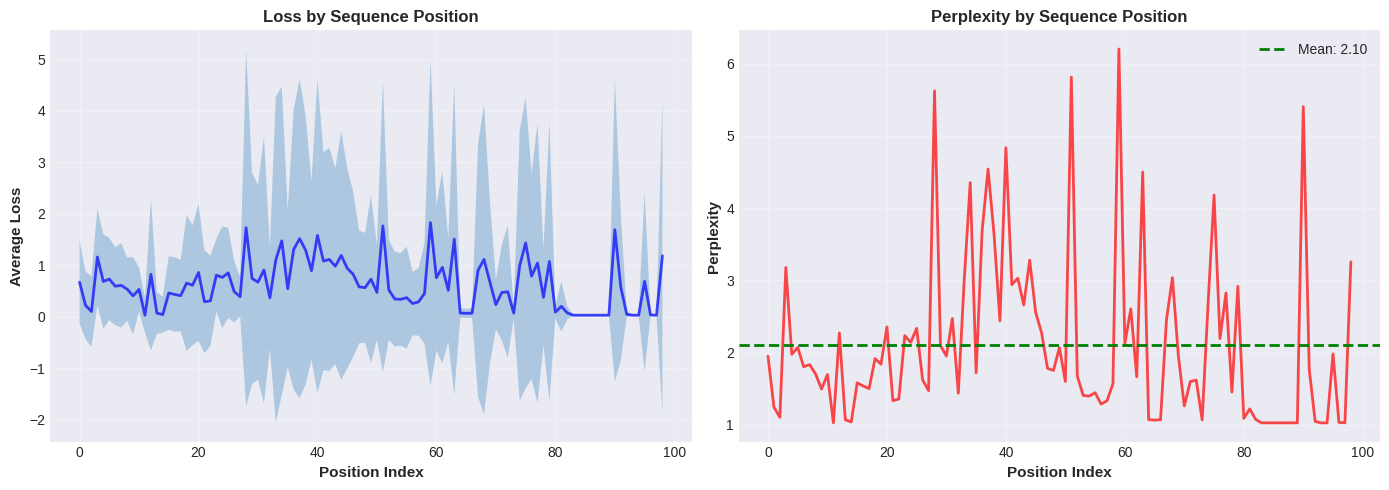

In [32]:
# 2. Entropy by Position Analysis
# Analyze perplexity/loss at each timestep position to detect boundary issues

print("="*70)
print("POSITIONAL ENTROPY ANALYSIS")
print("="*70)

# Collect loss per position
model.eval()
position_losses = defaultdict(list)  # position -> list of losses
position_counts = defaultdict(int)

print("\nComputing position-wise losses on validation set...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Position Analysis", leave=False):
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        logits = model(input_ids, attention_mask)
        
        # Compute loss per position
        for i in range(input_ids.size(1)):  # For each position
            mask = attention_mask[:, i] == 1  # Valid positions
            if mask.sum() == 0:
                continue
                
            pos_logits = logits[mask, i, :]
            pos_targets = target_ids[mask, i]
            
            # Filter out padding targets
            valid = pos_targets != pad_id
            if valid.sum() == 0:
                continue
                
            pos_loss = F.cross_entropy(pos_logits[valid], pos_targets[valid], reduction='none')
            position_losses[i].extend(pos_loss.cpu().tolist())
            position_counts[i] += valid.sum().item()

# Calculate statistics per position
position_stats = []
for pos in sorted(position_losses.keys()):
    losses = position_losses[pos]
    if len(losses) > 0:
        avg_loss = np.mean(losses)
        avg_ppl = np.exp(min(avg_loss, 50))  # Clamp for numerical stability
        std_loss = np.std(losses)
        position_stats.append({
            'position': pos,
            'avg_loss': avg_loss,
            'perplexity': avg_ppl,
            'std_loss': std_loss,
            'count': position_counts[pos]
        })

# Create DataFrame and display
pos_df = pd.DataFrame(position_stats)

print(f"\nPosition-wise Statistics (first 20 positions):")
print(pos_df.head(20).to_string(index=False))

if len(pos_df) > 20:
    print(f"\n... (showing first 20 of {len(pos_df)} positions)")
    print(f"\nLast 10 positions:")
    print(pos_df.tail(10).to_string(index=False))

# Identify high-entropy positions
high_entropy_threshold = pos_df['perplexity'].quantile(0.90)
high_entropy_positions = pos_df[pos_df['perplexity'] > high_entropy_threshold]

print(f"\n{'='*70}")
print(f"High-Entropy Positions (top 10%):")
print(f"{'='*70}")
if len(high_entropy_positions) > 0:
    print(high_entropy_positions.to_string(index=False))
    print(f"\nAnalysis: Positions {high_entropy_positions['position'].min()}-{high_entropy_positions['position'].max()} show elevated perplexity")
else:
    print("No significant high-entropy positions detected")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss by position
ax1 = axes[0]
ax1.plot(pos_df['position'], pos_df['avg_loss'], 'b-', linewidth=2, alpha=0.7)
ax1.fill_between(pos_df['position'], 
                  pos_df['avg_loss'] - pos_df['std_loss'],
                  pos_df['avg_loss'] + pos_df['std_loss'],
                  alpha=0.3)
ax1.set_xlabel('Position Index', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss by Sequence Position', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Perplexity by position
ax2 = axes[1]
ax2.plot(pos_df['position'], pos_df['perplexity'], 'r-', linewidth=2, alpha=0.7)
ax2.axhline(y=pos_df['perplexity'].mean(), color='green', linestyle='--', 
            label=f'Mean: {pos_df["perplexity"].mean():.2f}', linewidth=2)
ax2.set_xlabel('Position Index', fontsize=11, fontweight='bold')
ax2.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
ax2.set_title('Perplexity by Sequence Position', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'positional_entropy.png', dpi=300, bbox_inches='tight')
print(f"\nSaved positional entropy plot to: {checkpoint_dir / 'positional_entropy.png'}")
plt.show()

print(f"{'='*70}\n")

TOP-K NEXT-TEMPLATE ACCURACY

Computing top-k accuracy on validation set...


Computing Top-K Accuracy:   0%|          | 0/899 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


Computing top-k accuracy on test set...


Computing Top-K Accuracy:   0%|          | 0/899 [00:00<?, ?it/s]


VALIDATION SET (Total Predictions: 743,205)
  Top- 1 Accuracy:  78.55%
  Top- 3 Accuracy:  99.34%
  Top- 5 Accuracy:  99.95%
  Top-10 Accuracy:  99.99%

TEST SET (Total Predictions: 908,316)
  Top- 1 Accuracy:  80.78%
  Top- 3 Accuracy:  99.48%
  Top- 5 Accuracy:  99.97%
  Top-10 Accuracy:  99.99%

Saved top-k accuracy plot to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/topk_accuracy.png


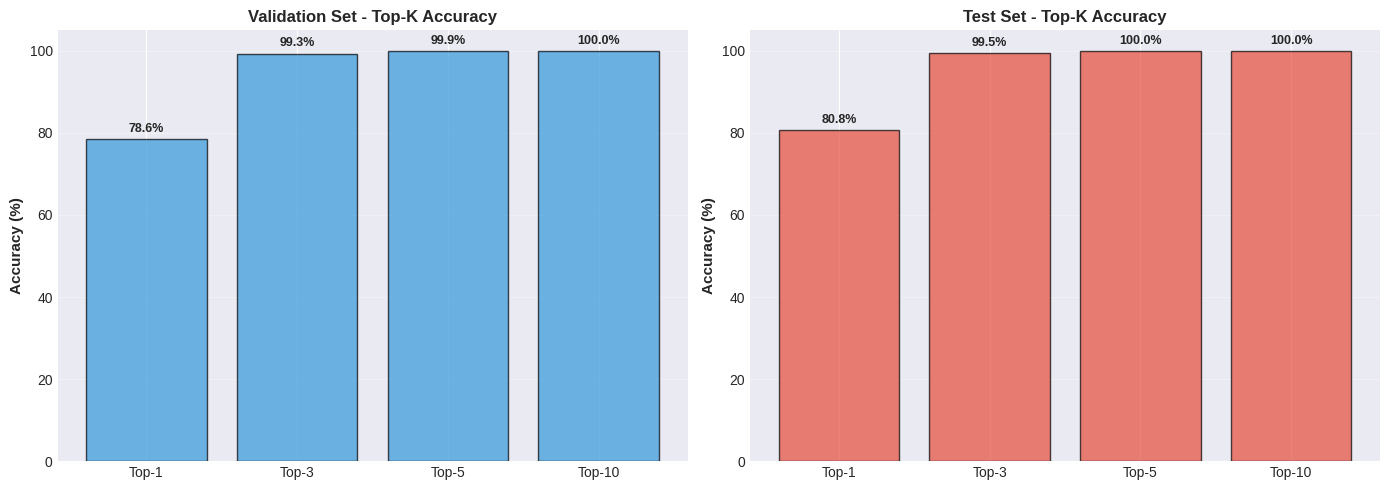


INTERPRETATION
Top-1 Accuracy: 78.55% - Model predicts exact next template
Top-5 Accuracy: 99.95% - Correct template in top 5 predictions
✓ Good: Model has reasonable prediction accuracy



In [33]:
# 3. Top-K Next-Template Accuracy Analysis
# Measure top-1, top-3, top-5 accuracy for interpretable performance check

print("="*70)
print("TOP-K NEXT-TEMPLATE ACCURACY")
print("="*70)

def compute_topk_accuracy(model, loader, k_values=[1, 3, 5, 10]):
    """Compute top-k accuracy for next template prediction"""
    model.eval()
    
    # Track hits per k
    total_predictions = 0
    topk_hits = {k: 0 for k in k_values}
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Computing Top-K Accuracy", leave=False):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            logits = model(input_ids, attention_mask)
            
            # Get valid predictions (not padding)
            valid_mask = target_ids != pad_id
            
            if valid_mask.sum() == 0:
                continue
            
            # Get logits and targets for valid positions
            valid_logits = logits[valid_mask]  # (num_valid, vocab_size)
            valid_targets = target_ids[valid_mask]  # (num_valid,)
            
            # Get top-k predictions for each position
            max_k = max(k_values)
            _, topk_indices = torch.topk(valid_logits, k=min(max_k, vocab_size), dim=1)
            
            # Check if target is in top-k for each k
            for k in k_values:
                if k > vocab_size:
                    continue
                topk_k = topk_indices[:, :k]  # (num_valid, k)
                # Check if target is in top-k
                hits = (topk_k == valid_targets.unsqueeze(1)).any(dim=1).sum().item()
                topk_hits[k] += hits
            
            total_predictions += valid_mask.sum().item()
    
    # Calculate accuracies
    accuracies = {k: (topk_hits[k] / total_predictions * 100) if total_predictions > 0 else 0 
                  for k in k_values}
    
    return accuracies, total_predictions

# Compute for validation set
print("\nComputing top-k accuracy on validation set...")
val_topk, val_total = compute_topk_accuracy(model, val_loader, k_values=[1, 3, 5, 10])

# Compute for test set
print("Computing top-k accuracy on test set...")
test_topk, test_total = compute_topk_accuracy(model, test_loader, k_values=[1, 3, 5, 10])

# Display results
print(f"\n{'='*70}")
print(f"VALIDATION SET (Total Predictions: {val_total:,})")
print(f"{'='*70}")
for k in sorted(val_topk.keys()):
    print(f"  Top-{k:2d} Accuracy: {val_topk[k]:6.2f}%")

print(f"\n{'='*70}")
print(f"TEST SET (Total Predictions: {test_total:,})")
print(f"{'='*70}")
for k in sorted(test_topk.keys()):
    print(f"  Top-{k:2d} Accuracy: {test_topk[k]:6.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

k_values = sorted(val_topk.keys())
val_accs = [val_topk[k] for k in k_values]
test_accs = [test_topk[k] for k in k_values]

# Validation Top-K
ax1 = axes[0]
bars1 = ax1.bar(range(len(k_values)), val_accs, color='#3498db', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(k_values)))
ax1.set_xticklabels([f'Top-{k}' for k in k_values])
ax1.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('Validation Set - Top-K Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 105)
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, acc in zip(bars1, val_accs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Test Top-K
ax2 = axes[1]
bars2 = ax2.bar(range(len(k_values)), test_accs, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(k_values)))
ax2.set_xticklabels([f'Top-{k}' for k in k_values])
ax2.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax2.set_title('Test Set - Top-K Accuracy', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, acc in zip(bars2, test_accs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'topk_accuracy.png', dpi=300, bbox_inches='tight')
print(f"\nSaved top-k accuracy plot to: {checkpoint_dir / 'topk_accuracy.png'}")
plt.show()

# Interpretation
print(f"\n{'='*70}")
print(f"INTERPRETATION")
print(f"{'='*70}")
print(f"Top-1 Accuracy: {val_topk[1]:.2f}% - Model predicts exact next template")
print(f"Top-5 Accuracy: {val_topk[5]:.2f}% - Correct template in top 5 predictions")
if val_topk[1] > 80:
    print("✓ Excellent: Model has strong deterministic prediction capability")
elif val_topk[1] > 60:
    print("✓ Good: Model has reasonable prediction accuracy")
elif val_topk[1] > 40:
    print("⚠ Moderate: Some uncertainty in predictions")
else:
    print("⚠ Low: High uncertainty - may indicate complex patterns or noise")

print(f"{'='*70}\n")

In [34]:
# 4. Save Diagnostic Results

print("="*70)
print("SAVING DIAGNOSTIC RESULTS")
print("="*70)

# Compile all diagnostic metrics
diagnostic_results = {
    'template_coverage': {
        'train_unique_templates': int(len(train_templates)),
        'val_unique_templates': int(len(val_templates)),
        'test_unique_templates': int(len(test_templates)),
        'val_unseen_templates': int(len(val_unseen)),
        'test_unseen_templates': int(len(test_unseen)),
        'val_coverage_pct': float(val_coverage),
        'test_coverage_pct': float(test_coverage),
        'val_unseen_template_ids': sorted(list(val_unseen))[:50],  # First 50
        'test_unseen_template_ids': sorted(list(test_unseen))[:50]  # First 50
    },
    'positional_entropy': {
        'total_positions_analyzed': len(pos_df),
        'avg_perplexity_across_positions': float(pos_df['perplexity'].mean()),
        'std_perplexity_across_positions': float(pos_df['perplexity'].std()),
        'min_perplexity_position': int(pos_df.loc[pos_df['perplexity'].idxmin(), 'position']),
        'max_perplexity_position': int(pos_df.loc[pos_df['perplexity'].idxmax(), 'position']),
        'min_perplexity_value': float(pos_df['perplexity'].min()),
        'max_perplexity_value': float(pos_df['perplexity'].max()),
        'high_entropy_positions': high_entropy_positions['position'].tolist() if len(high_entropy_positions) > 0 else []
    },
    'topk_accuracy': {
        'validation': {
            'total_predictions': int(val_total),
            'top1_accuracy_pct': float(val_topk[1]),
            'top3_accuracy_pct': float(val_topk[3]),
            'top5_accuracy_pct': float(val_topk[5]),
            'top10_accuracy_pct': float(val_topk[10])
        },
        'test': {
            'total_predictions': int(test_total),
            'top1_accuracy_pct': float(test_topk[1]),
            'top3_accuracy_pct': float(test_topk[3]),
            'top5_accuracy_pct': float(test_topk[5]),
            'top10_accuracy_pct': float(test_topk[10])
        }
    }
}

# Save diagnostics to JSON
diagnostics_path = metrics_dir / 'hdfs_transformer_diagnostics.json'
with open(diagnostics_path, 'w') as f:
    json.dump(diagnostic_results, f, indent=2)

print(f"\nSaved diagnostic results to: {diagnostics_path}")

# Save positional statistics to CSV
pos_csv_path = checkpoint_dir / 'positional_entropy.csv'
pos_df.to_csv(pos_csv_path, index=False)
print(f"Saved positional entropy data to: {pos_csv_path}")

# Create diagnostic summary
print(f"\n{'='*70}")
print(f"DIAGNOSTIC SUMMARY")
print(f"{'='*70}")
print(f"\n1. Template Coverage:")
print(f"   - Val coverage: {val_coverage:.2f}% ({'✓ Excellent' if val_coverage > 95 else '⚠ Some gaps'})")
print(f"   - Test coverage: {test_coverage:.2f}% ({'✓ Excellent' if test_coverage > 95 else '⚠ Some gaps'})")

print(f"\n2. Positional Entropy:")
print(f"   - Avg perplexity: {pos_df['perplexity'].mean():.2f}")
print(f"   - Range: {pos_df['perplexity'].min():.2f} - {pos_df['perplexity'].max():.2f}")
print(f"   - High-entropy positions: {len(high_entropy_positions)} ({'✓ Uniform' if len(high_entropy_positions) < 5 else '⚠ Some spikes'})")

print(f"\n3. Top-K Accuracy:")
print(f"   - Top-1 (Val): {val_topk[1]:.2f}% ({'✓ Excellent' if val_topk[1] > 80 else '✓ Good' if val_topk[1] > 60 else '⚠ Moderate'})")
print(f"   - Top-5 (Val): {val_topk[5]:.2f}%")
print(f"   - Top-1 (Test): {test_topk[1]:.2f}%")

print(f"\n{'='*70}")
print(f"All diagnostic outputs saved!")
print(f"{'='*70}\n")

print("📊 Diagnostic Files Generated:")
print(f"  • {diagnostics_path}")
print(f"  • {pos_csv_path}")
print(f"  • {checkpoint_dir / 'positional_entropy.png'}")
print(f"  • {checkpoint_dir / 'topk_accuracy.png'}")
print(f"\n✅ Diagnostic analysis complete!\n")

SAVING DIAGNOSTIC RESULTS

Saved diagnostic results to: /home/tpi/distil_shahreyar/artifacts/metrics/hdfs/hdfs_transformer_diagnostics.json
Saved positional entropy data to: /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/positional_entropy.csv

DIAGNOSTIC SUMMARY

1. Template Coverage:
   - Val coverage: 97.37% (✓ Excellent)
   - Test coverage: 100.00% (✓ Excellent)

2. Positional Entropy:
   - Avg perplexity: 2.10
   - Range: 1.03 - 6.20
   - High-entropy positions: 10 (⚠ Some spikes)

3. Top-K Accuracy:
   - Top-1 (Val): 78.55% (✓ Good)
   - Top-5 (Val): 99.95%
   - Top-1 (Test): 80.78%

All diagnostic outputs saved!

📊 Diagnostic Files Generated:
  • /home/tpi/distil_shahreyar/artifacts/metrics/hdfs/hdfs_transformer_diagnostics.json
  • /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/positional_entropy.csv
  • /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/positional_entropy.png
  • /home/tpi/distil_shahreyar/artifacts/hdfs_transformer/topk_accuracy.png

✅ Diagno